In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

In [2]:
data = pd.read_csv("dataset_mood_smartphone.csv", index_col=0)              # Load the data                                                    
data[['date', 'time']] = data['time'].str.split(' ', expand=True) 
data.head()

,id,time,variable,value,date
1,AS14.01,13:00:00.000,mood,6.0,2014-02-26
2,AS14.01,15:00:00.000,mood,6.0,2014-02-26
3,AS14.01,18:00:00.000,mood,6.0,2014-02-26
4,AS14.01,21:00:00.000,mood,7.0,2014-02-26
5,AS14.01,09:00:00.000,mood,6.0,2014-02-27


In [3]:
data_mood = data[data["variable"] == "mood" ]                               # Select the rows where the variable is "mood"
result_mood = data_mood.groupby(['id', 'date']).agg({'value': 'mean'}).reset_index()   # Group by id and date and calculate the mean of the value column

In [4]:
result_mood.describe()

,value
count,1268.000000
mean,6.990063
std,0.736465
min,3.000000
25%,6.600000
50%,7.000000
75%,7.500000
max,9.333333


In [5]:
unique_dates = result_mood['date'].unique()  # Get the unique dates
unique_ids = result_mood["id"].unique()      # Get the unique ids
print(len(unique_dates))                # Print the number of unique dates
print(len(unique_ids))                  # Print the number of unique ids

98
27


<Axes: xlabel='value', ylabel='Count'>

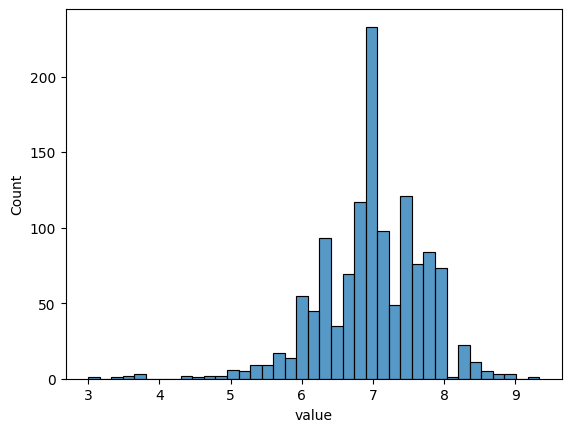

In [6]:
sns.histplot(result_mood, x="value")  # Create a histogram of the values

In [7]:
data["variable"].unique()

array(['mood', 'circumplex.arousal', 'circumplex.valence', 'activity',
       'screen', 'call', 'sms', 'appCat.builtin', 'appCat.communication',
       'appCat.entertainment', 'appCat.finance', 'appCat.game',
       'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel',
       'appCat.unknown', 'appCat.utilities', 'appCat.weather'],
      dtype=object)

In [8]:
data_arousal = data[data["variable"] == "circumplex.arousal"]
data_screen = data[data["variable"] == "screen"]                # Select the rows where the variable is "screen"
data_valence = data[data["variable"] == "circumplex.valence"]   # Select the rows where the variable is "circumplex.valence"
data_activity = data[data["variable"] == "activity"]            # Select the rows where the variable is "activity"  
data_call = data[data["variable"] == "call"]
data_sms = data[data["variable"] == "sms"]
data_built_in = data[data["variable"] == "appCat.builtin"]  
data_communication = data[data["variable"] == "appCat.communication"]
data_entertainment = data[data["variable"] == "appCat.entertainment"]
data_finance = data[data["variable"] == "appCat.finance"]
data_game = data[data["variable"] == "appCat.game"]
data_office = data[data["variable"] == "appCat.office"]
data_other = data[data["variable"] == "appCat.other"]
data_social = data[data["variable"] == "appCat.social"]
data_travel = data[data["variable"] == "appCat.travel"]
data_unknown = data[data["variable"] == "appCat.unknown"]
data_utility = data[data["variable"] == "appCat.utilities"]
data_weather = data[data["variable"] == "appCat.weather"]

In [28]:
result_screen = data_screen.groupby(['id', 'date']).agg({'value': 'sum'}).reset_index().rename(columns={'value': 'screen_time'})
result_arousal = data_arousal.groupby(['id', 'date']).agg({'value': 'mean'}).reset_index().rename(columns={'value': 'arousal_value'})
result_valence = data_valence.groupby(['id', 'date']).agg({'value': 'mean'}).reset_index().rename(columns={'value': 'valence_value'})
result_activity = data_activity.groupby(['id', 'date']).agg({"value": "mean"}).reset_index().rename(columns={'value': 'activity_time'})
result_call = data_call.groupby(['id', 'date']).agg({"value":"sum"}).reset_index().rename(columns={'value': 'call_time'})
result_sms = data_sms.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'sms_time'})
result_built_in = data_built_in.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'built_in_time'})
result_communication = data_communication.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'communication_time'})
result_entertainment = data_entertainment.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'entertainment_time'})
result_finance = data_finance.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'finance_time'})
result_game = data_game.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'game_time'})
result_office = data_office.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'office_time'})
result_other = data_other.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'other_time'})
result_social = data_social.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'social_time'})
result_travel = data_travel.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'travel_time'})    
result_unknown = data_unknown.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'unknown_time'})
result_utility = data_utility.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'utility_time'})
result_weather = data_weather.groupby(['id', 'date']).agg({"value" : "sum"}).reset_index().rename(columns={'value': 'weather_time'})



In [30]:
result_call.head()

,id,date,call_time
0,AS14.01,2014-02-17,2.0
1,AS14.01,2014-02-18,1.0
2,AS14.01,2014-02-19,7.0
3,AS14.01,2014-02-20,2.0
4,AS14.01,2014-02-22,2.0


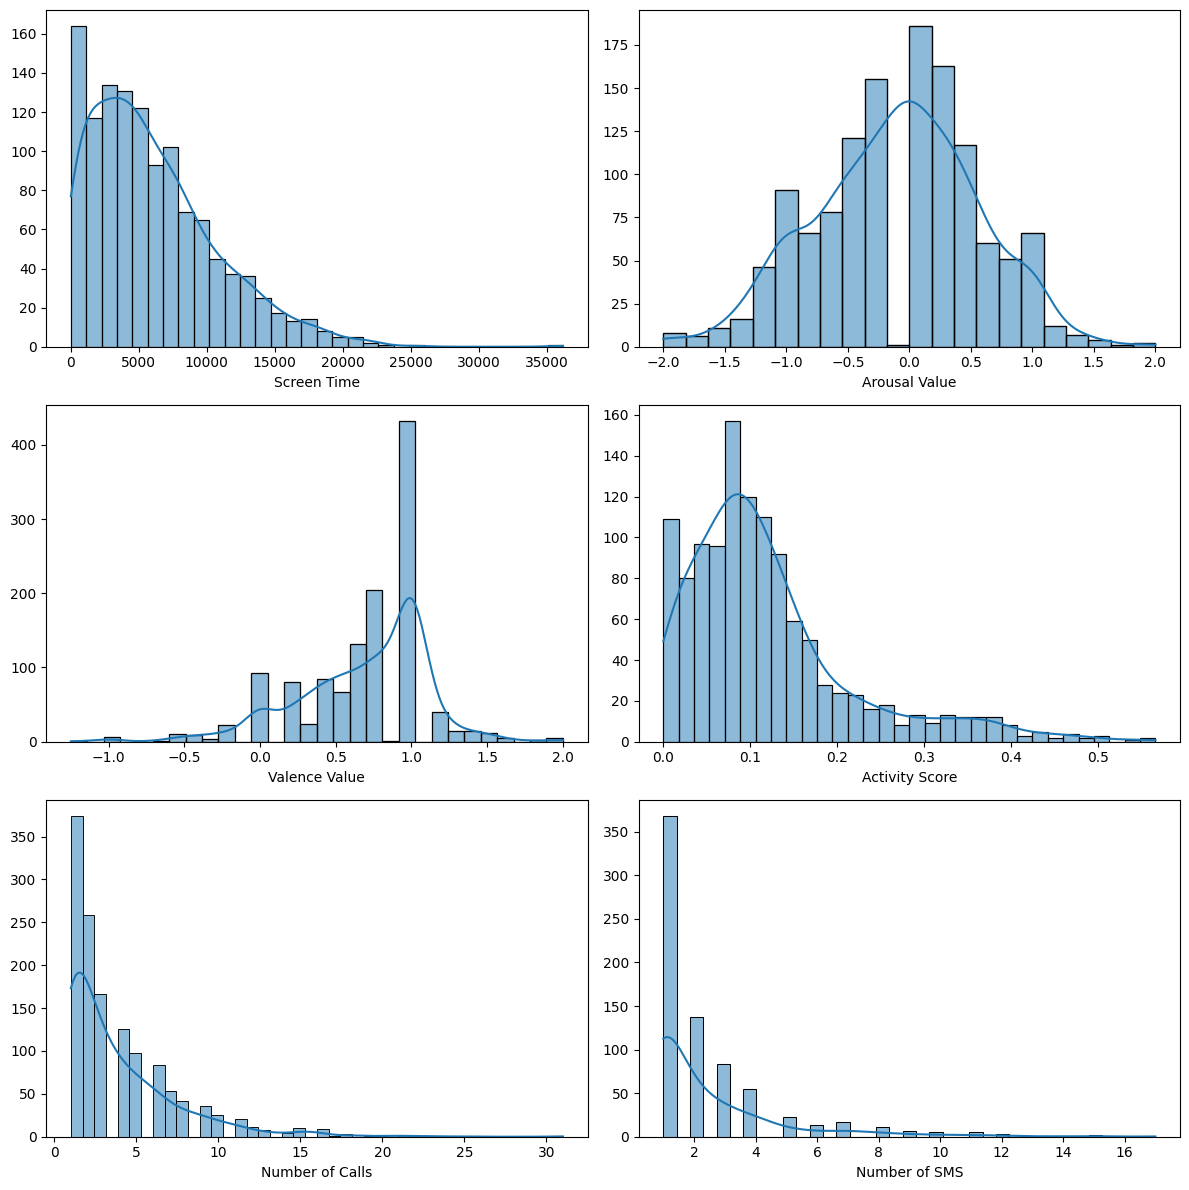

In [33]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting histograms for each activity
sns.histplot(data=result_screen, x="screen_time", label="Screen", kde=True, ax=axes[0])
axes[0].set_xlabel("Screen Time")

sns.histplot(data=result_arousal, x="arousal_value", label="Arousal", kde=True, ax=axes[1])
axes[1].set_xlabel("Arousal Value")

sns.histplot(data=result_valence, x="valence_value", label="Valence", kde=True, ax=axes[2])
axes[2].set_xlabel("Valence Value")

sns.histplot(data=result_activity, x="activity_time", label="Activity", kde=True, ax=axes[3])
axes[3].set_xlabel("Activity Score")

sns.histplot(data=result_call, x="call_time", label="Call", kde=True, ax=axes[4])
axes[4].set_xlabel("Number of Calls")

sns.histplot(data=result_sms, x="sms_time", label="SMS", kde=True, ax=axes[5])
axes[5].set_xlabel("Number of SMS")

# Removing y-axis label to save space
for ax in axes:
    ax.set_ylabel("")

plt.tight_layout()
plt.show()



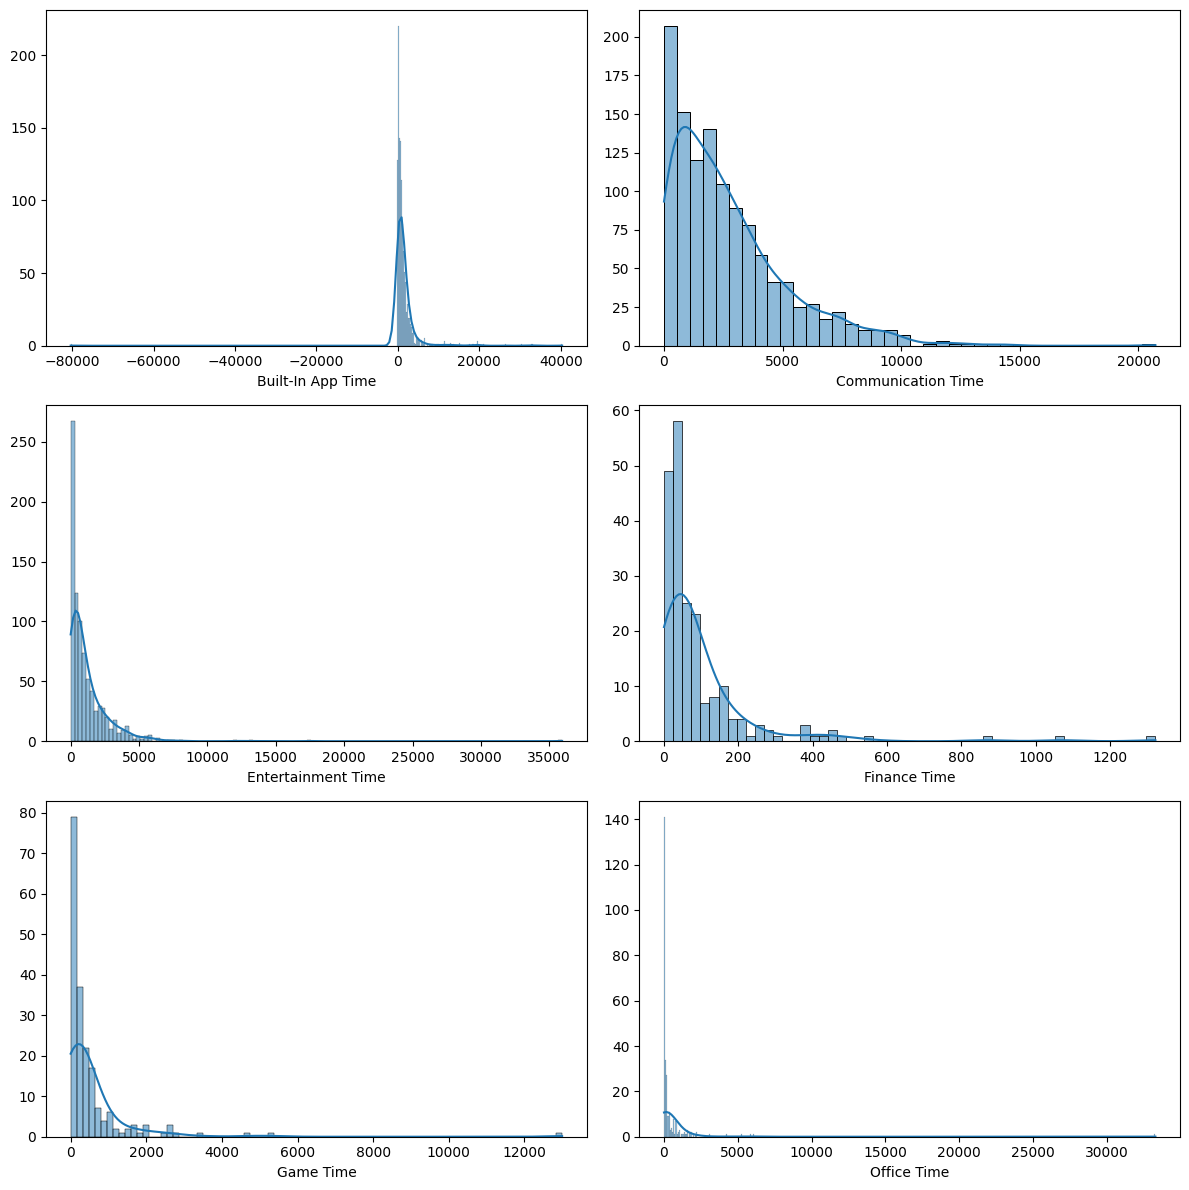

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting histograms for each activity
sns.histplot(data=result_built_in, x="built_in_time", label="Built-In App", kde=True, ax=axes[0])
axes[0].set_xlabel("Built-In App Time")

sns.histplot(data=result_communication, x="communication_time", label="Communication", kde=True, ax=axes[1])
axes[1].set_xlabel("Communication Time")

sns.histplot(data=result_entertainment, x="entertainment_time", label="Entertainment", kde=True, ax=axes[2])
axes[2].set_xlabel("Entertainment Time")

sns.histplot(data=result_finance, x="finance_time", label="Finance", kde=True, ax=axes[3])
axes[3].set_xlabel("Finance Time")

sns.histplot(data=result_game, x="game_time", label="Game", kde=True, ax=axes[4])
axes[4].set_xlabel("Game Time")

sns.histplot(data=result_office, x="office_time", label="Office", kde=True, ax=axes[5])
axes[5].set_xlabel("Office Time")

# Removing y-axis label to save space
for ax in axes:
    ax.set_ylabel("")

plt.tight_layout()
plt.show()


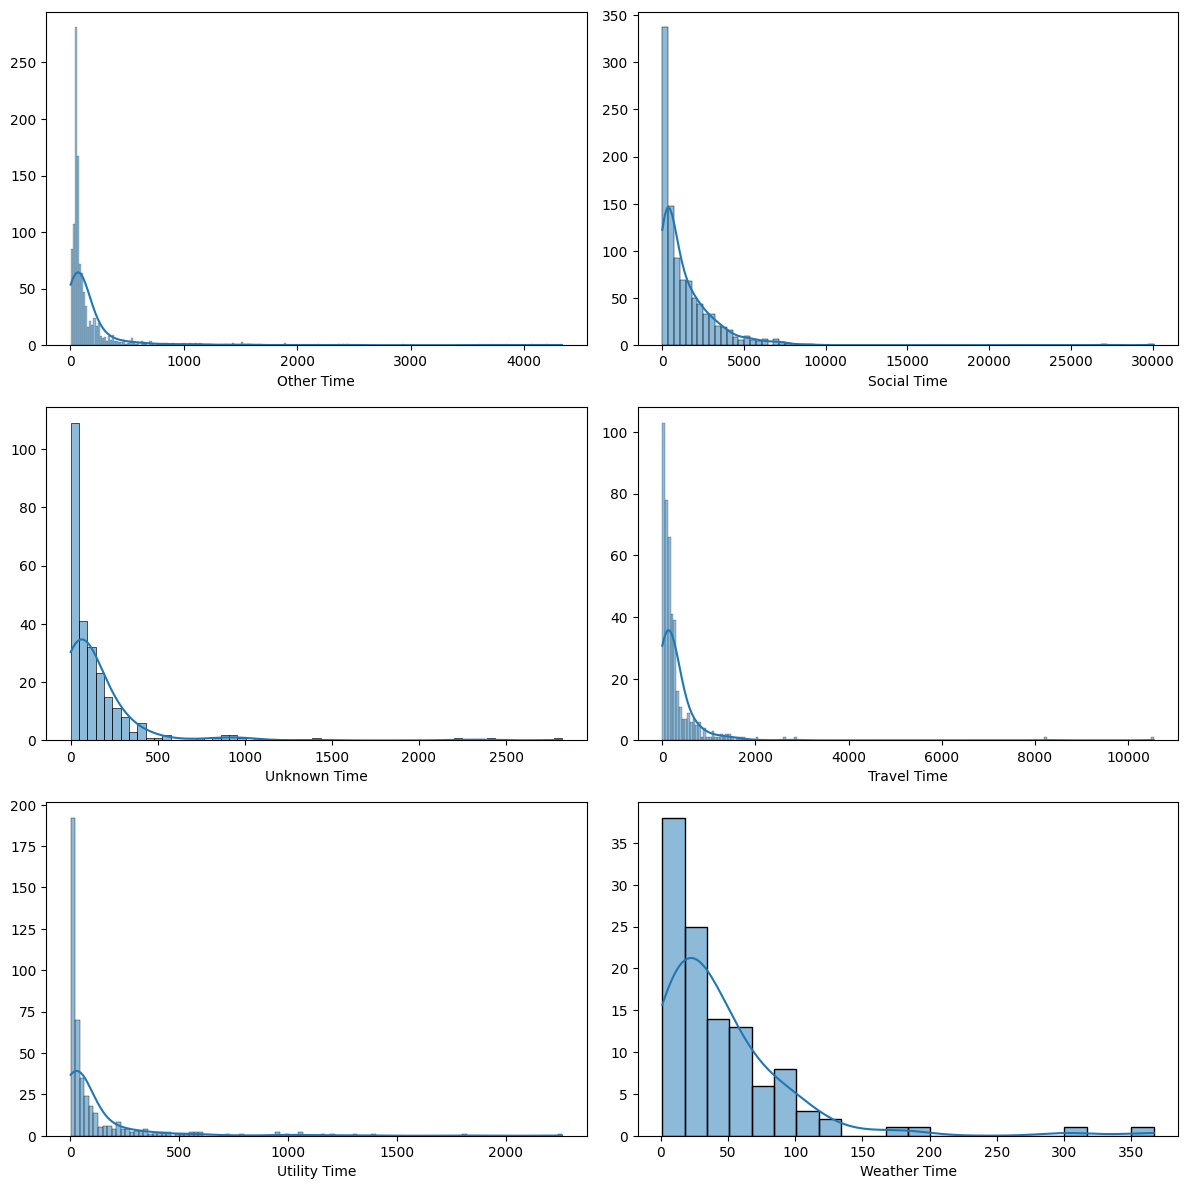

In [22]:
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
axes = axes.flatten()

# Plotting histograms for each activity
sns.histplot(data=result_other, x="other_time", label="Other", kde=True, ax=axes[0])
axes[0].set_xlabel("Other Time")

sns.histplot(data=result_social, x="social_time", label="Social", kde=True, ax=axes[1])
axes[1].set_xlabel("Social Time")

sns.histplot(data=result_unknown, x="unknown_time", label="Unknown", kde=True, ax=axes[2])
axes[2].set_xlabel("Unknown Time")

sns.histplot(data=result_travel, x="travel_time", label="Travel", kde=True, ax=axes[3])
axes[3].set_xlabel("Travel Time")

sns.histplot(data=result_utility, x="utility_time", label="Utility", kde=True, ax=axes[4])
axes[4].set_xlabel("Utility Time")

sns.histplot(data=result_weather, x="weather_time", label="Weather", kde=True, ax=axes[5])
axes[5].set_xlabel("Weather Time")

# Removing y-axis label to save space
for ax in axes:
    ax.set_ylabel("")

plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(data)
# Use pivot_table to create new columns for each unique value in 'variable' column
df_pivoted = df.pivot_table(index=['id', 'time', 'date'], columns='variable', values='value').reset_index()


In [ ]:
df_pivoted[['date', 'time']] = df_pivoted['time'].str.split(' ', expand=True)               # Split the time column into date and time
#result = df2.groupby(['id', 'date']).agg({'value': 'mean'}).reset_index()

In [35]:
result_combined = result_screen.join(result_arousal.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_valence.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_activity.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_call.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_sms.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_built_in.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_communication.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_entertainment.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_finance.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_game.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_office.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_other.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_social.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_travel.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_unknown.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_utility.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_weather.set_index(['id', 'date']), on=['id', 'date'])
result_combined = result_combined.join(result_mood.set_index(['id', 'date']), on=['id', 'date'])

In [47]:
final_df = result_combined.drop(columns=['id'])     # Drop the id column

In [48]:
final_df

,date,screen_time,arousal_value,valence_value,activity_time,call_time,sms_time,built_in_time,communication_time,entertainment_time,finance_time,game_time,office_time,other_time,social_time,travel_time,unknown_time,utility_time,weather_time,value
0,2014-03-20,2275.944000,NaN,NaN,0.081548,1.0,NaN,248.979,2168.229,350.856,NaN,NaN,NaN,11.345,807.731,NaN,45.173,21.074,NaN,NaN
1,2014-03-21,17978.907000,0.200000,0.2,0.134050,6.0,NaN,3139.218,6280.890,1007.456,49.544,NaN,172.206,239.751,4508.500,915.445,NaN,598.754,NaN,6.2
2,2014-03-22,6142.161000,0.600000,0.5,0.236880,3.0,1.0,731.429,4962.918,93.324,21.076,NaN,NaN,98.143,439.632,37.305,NaN,117.621,NaN,6.4
3,2014-03-23,6773.832001,0.200000,0.8,0.142741,NaN,NaN,1286.246,5237.319,94.346,43.403,NaN,NaN,72.823,900.839,NaN,NaN,30.086,30.386,6.8
4,2014-03-24,15047.351001,0.800000,0.0,0.078961,10.0,NaN,866.956,9270.629,976.971,34.106,NaN,3.010,66.558,3223.626,419.805,NaN,178.732,NaN,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,2014-05-26,18925.187999,-0.400000,0.0,0.115201,10.0,3.0,1048.739,1235.537,688.769,NaN,NaN,130.530,235.837,5441.264,NaN,NaN,NaN,NaN,5.4
1203,2014-05-27,4089.879001,-0.600000,0.4,0.012704,1.0,2.0,726.391,2078.403,124.694,NaN,NaN,NaN,142.686,2010.364,NaN,NaN,56.173,NaN,6.2
1204,2014-05-28,14320.867998,0.000000,1.2,0.103301,10.0,1.0,2551.046,1936.415,614.706,NaN,NaN,357.909,529.946,5361.211,NaN,NaN,30.666,NaN,8.2
1205,2014-05-29,3569.341000,-1.333333,1.0,0.169354,5.0,1.0,400.034,435.105,136.738,NaN,NaN,NaN,29.202,1789.922,0.939,NaN,3.199,NaN,7.0


In [49]:
final_df = final_df.groupby(['date']).agg({'screen_time': 'mean', 'arousal_value': 'mean', 'valence_value': 'mean', 'activity_time': 'mean', 'call_time': 'mean', 'sms_time': 'mean', 'built_in_time': 'mean', 'communication_time': 'mean', 'entertainment_time': 'mean', 'finance_time': 'mean', 'game_time': 'mean', 'office_time': 'mean', 'other_time': 'mean', 'social_time': 'mean', 'travel_time': 'mean', 'unknown_time': 'mean', 'utility_time': 'mean', 'weather_time': 'mean', 'value': 'mean'}).reset_index()

In [51]:
final_df.head()

,date,screen_time,arousal_value,valence_value,activity_time,call_time,sms_time,built_in_time,communication_time,entertainment_time,finance_time,game_time,office_time,other_time,social_time,travel_time,unknown_time,utility_time,weather_time,value
0,2014-03-13,761.514667,-0.833333,1.033333,NaN,3.00,11.000000,94.292667,328.329333,73.508000,NaN,NaN,NaN,338.045500,187.52150,NaN,NaN,13.062,NaN,7.200000
1,2014-03-14,3031.056667,-0.330000,1.170000,NaN,3.75,4.500000,514.415500,1784.831167,176.657000,NaN,NaN,NaN,339.535667,574.44625,2069.880,180.247,24.383,NaN,7.420000
2,2014-03-15,3449.913000,0.150000,0.540000,NaN,6.00,2.666667,917.163167,2081.339333,643.394600,40.192,NaN,17.086,353.489000,483.43425,125.700,186.877,41.317,NaN,6.550000
3,2014-03-16,3635.274999,-0.743333,0.390000,NaN,3.50,2.000000,658.056600,1973.026600,302.228667,19.082,NaN,NaN,591.484200,407.39800,NaN,98.661,19.746,NaN,6.533333
4,2014-03-17,3509.016000,-0.083333,0.416667,0.063542,6.00,2.000000,534.430833,2700.993800,1766.000000,NaN,NaN,NaN,207.382400,1929.94375,236.148,7.068,15.923,NaN,6.391667


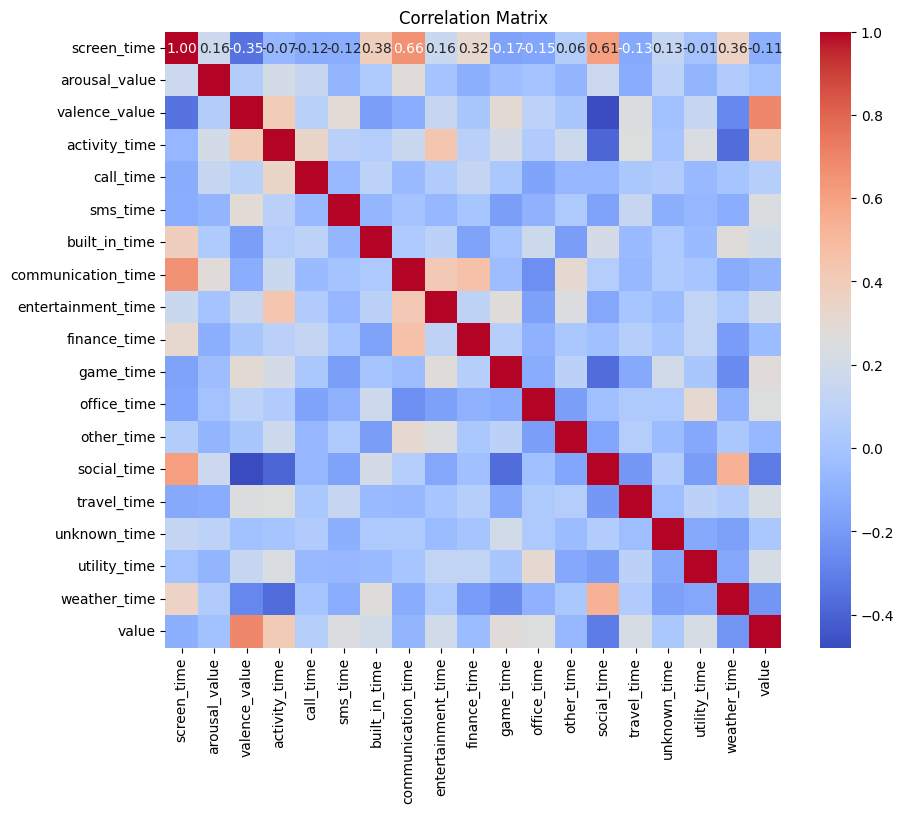

In [52]:
final_df = final_df.drop(columns=['date'])     # Drop the date column
# Calculate correlation matrix
corr_matrix = final_df .corr()

# Plot correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix')
plt.show()